In [1]:
import tensorflow as tf
import numpy as np
from IPython import display
from pathlib import Path

from lib.data import SequenceGenerator
from lib.image import write_png

box_size = 49

2023-04-27 01:25:24.145785: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 01:25:24.268499: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 01:25:24.269091: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 01:25:25.849893: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


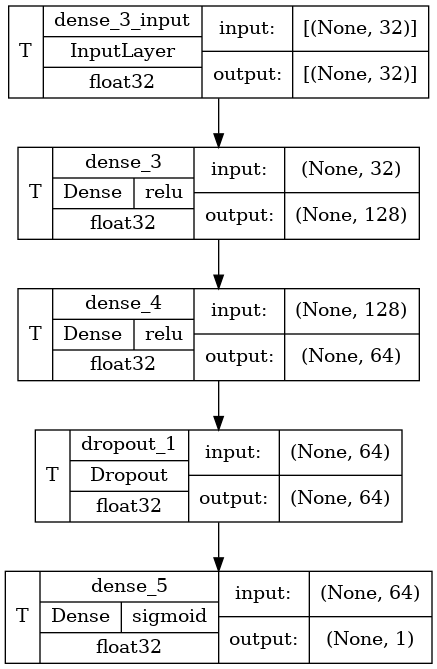

In [10]:


dropout = tf.keras.layers.Dropout(0.5)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation='relu', input_shape=(32,)),
  tf.keras.layers.Dense(64, activation='relu'),
  dropout,
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()]
              )

tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True, show_trainable=True)
display.Image(f'model.png')

In [2]:
gen = SequenceGenerator('img/project-1-at-2023-04-26-18-24-a552911a.json', 'img/raw')
train_data = gen.create_conv_sequence(box_size, 32, False)
validation_data = gen.create_conv_sequence(box_size, 512, True)


In [12]:
import datetime

dropout = model.get_layer('dropout_1')
model.optimizer.learning_rate = 0.0005
dropout.rate = 0.9

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model.fit(x=train_data,
          epochs=20,
          validation_data=validation_data,
          callbacks=[tensorboard_callback])

Epoch 1/20
  1/226 [..............................] - ETA: 31s - loss: 0.0143 - binary_accuracy: 1.0000 - false_negatives_1: 0.0000e+00 - false_positives_1: 0.0000e+00

2023-04-27 01:16:15.826913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


226/226 [==============================] - ETA: 0s - loss: 0.0228 - binary_accuracy: 0.9923 - false_negatives_1: 28.0000 - false_positives_1: 28.0000

2023-04-27 01:16:25.423678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


226/226 [==============================] - 11s 49ms/step - loss: 0.0228 - binary_accuracy: 0.9923 - false_negatives_1: 28.0000 - false_positives_1: 28.0000 - val_loss: 0.0224 - val_binary_accuracy: 0.9892 - val_false_negatives_1: 9.0000 - val_false_positives_1: 9.0000
Epoch 2/20
226/226 [==============================] - 12s 51ms/step - loss: 0.0256 - binary_accuracy: 0.9920 - false_negatives_1: 30.0000 - false_positives_1: 28.0000 - val_loss: 0.0251 - val_binary_accuracy: 0.9880 - val_false_negatives_1: 9.0000 - val_false_positives_1: 11.0000
Epoch 3/20
226/226 [==============================] - 12s 55ms/step - loss: 0.0244 - binary_accuracy: 0.9916 - false_negatives_1: 28.0000 - false_positives_1: 33.0000 - val_loss: 0.0259 - val_binary_accuracy: 0.9892 - val_false_negatives_1: 6.0000 - val_false_positives_1: 12.0000
Epoch 4/20
226/226 [==============================] - 10s 43ms/step - loss: 0.0232 - binary_accuracy: 0.9927 - false_negatives_1: 29.0000 - false_positives_1: 24.0000 - 

In [14]:
model.save_weights('model.tf')
model.save('model-all')

2023-04-27 01:22:48.628760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-27 01:22:49.022473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model-all/assets


INFO:tensorflow:Assets written to: model-all/assets


In [31]:
model.load_weights('model.tf')

In [3]:
model = tf.keras.models.load_model('model-all')

In [6]:
for i in range(len(validation_data)):
    batch_x, batch_y = validation_data[i]
    batch_r = model(batch_x)
    for k in range(len(batch_x)):
        y = round(float(batch_y[k]))
        r = round(float(batch_r[k]))
        if y != r:
            data, image, image_data = validation_data.get_details(i, k)
            name = f'./tmp/{r}-{y}--{i}-{k}--{data[1]}x{data[2]}.png'
            #print(name, image_data.info.file, image_data.info.slice_index)
            write_png(name, image)


KeyboardInterrupt: 

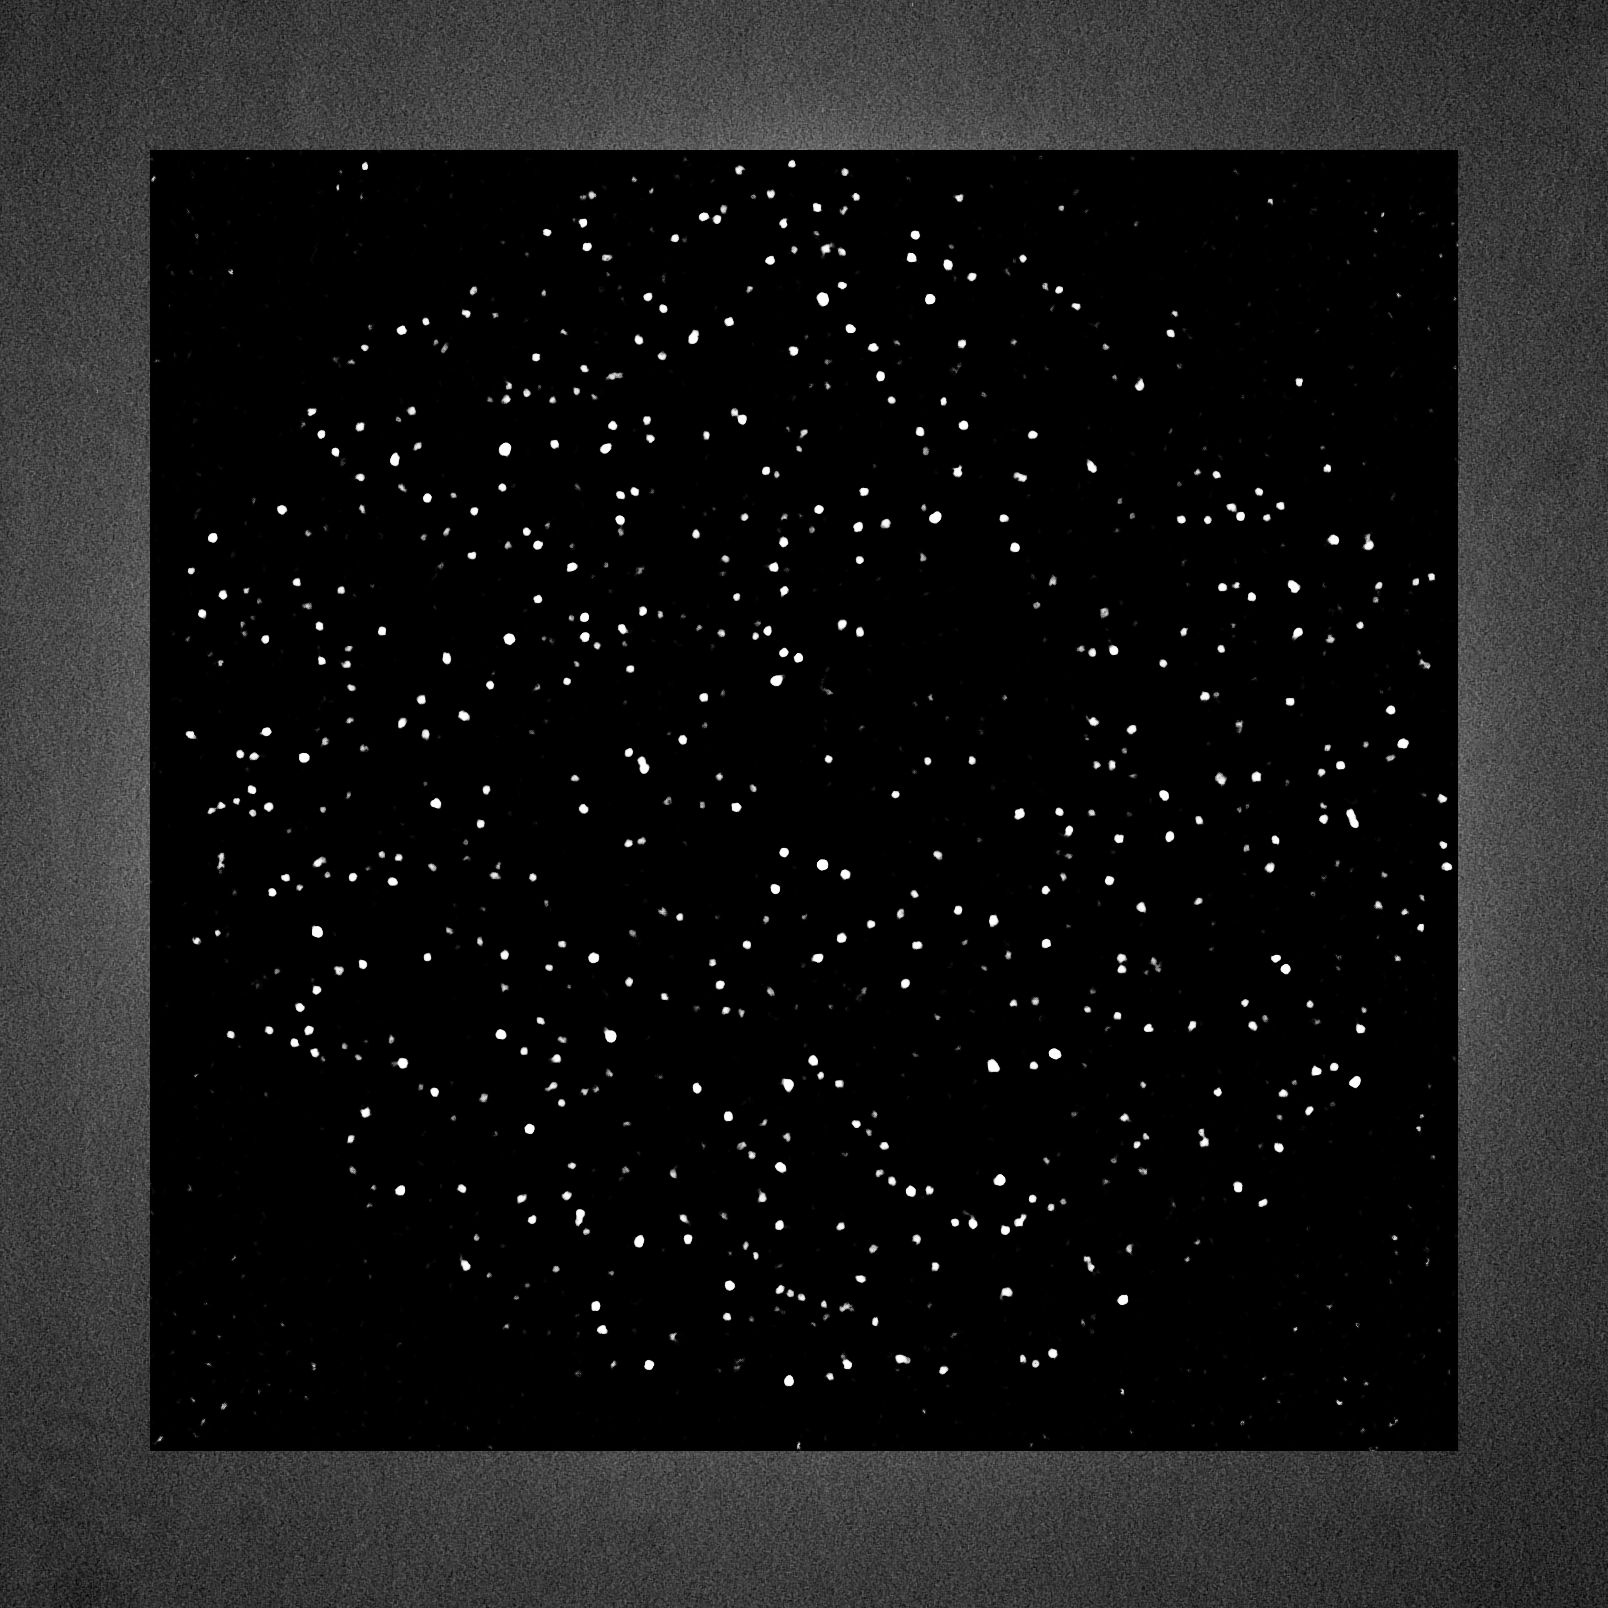

In [26]:

data, image, image_data = validation_data.get_details(0, 0)
out = np.array(image_data.data)
#for y in range(box_size, image_data.info.height - box_size):
for y in range(150, 1608-150):
    sec = []
    for x in range(150, 1608-150):
        sec.append(validation_data._get_section((0, x, y, 0)))
    res = model(np.array(sec))
    out[y, 150:1608-150] = res.numpy().reshape((1308,))
    print(f'{y}   ', end='\r')
    if y % 50 == 0:
        write_png('./tmp/a.png', out)
display.Image(f'./tmp/a.png')